#  Isolating the Poroelastic Response of the Groundwater System in InSAR Data from the Central Valley of California

## Workflow

### Step 1: K-means clustering 
### Step 2: Estimation of loading data 
-  Step 2-1: PCA 
-  Step 2-2: Polynomial fitting 

### Step 3: Isolation of poroelastic data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import json
import matplotlib.path as mpltPath
import json
import warnings
warnings.simplefilter("ignore")

C:\Users\sgkan\anaconda3\envs\geo_env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [47]:
!mkdir figures

A subdirectory or file figures already exists.


In [3]:
work_dir ="./figures/"

## Load InSAR data in netCDF format

In [1]:
import wget
#downlaod insar data
url = 'https://stacks.stanford.edu/file/druid:kj423qn1813/insar_data.nc'  
wget.download(url, '../data/input_data/', bar=None) 

'../data/input_data//insar_data.nc'

In [5]:
ds = xr.open_dataset("../data/input_data/insar_data.nc")

In [9]:
# Need to update the location of the file
cv_line = geopandas.read_file("../data/input_data/cv_line/cv_line.shp")
g = json.loads(cv_line.to_json())
coords = np.array(g['features'][0]['geometry']['coordinates'])
xy_cv = np.vstack(coords[0])[:,:2]
path_cv = mpltPath.Path(xy_cv)
X, Y = np.meshgrid(ds.lon.values, ds.lat.values)
data = ds.insar_median.values[-1,:,:]
inds_active_int = ~np.isnan(data)
inds_cv = path_cv.contains_points(np.c_[X.flatten(), Y.flatten()])

In [10]:
from scipy.spatial import cKDTree
tree = cKDTree(np.c_[X[inds_active_int], Y[inds_active_int]])
d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k = 50)
epsilon = 0.01
w = 1.0 / (d+epsilon)**1
data_idw = np.sum(w * data[inds_active_int][inds_idw], axis=1) / np.sum(w, axis=1)
tmp = data_idw.copy()
tmp[~inds_cv] = np.nan
DATA_IDW = tmp.reshape(X.shape)

Text(0.5, 139.0568661662709, 'Longitude')

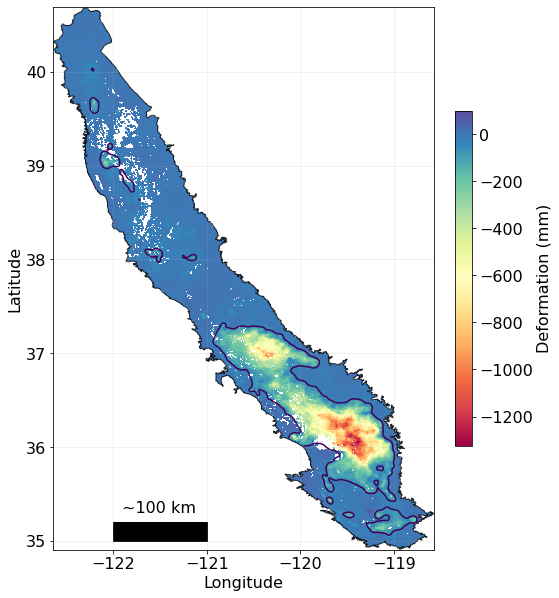

In [11]:
matplotlib.rcParams['font.size'] = 16
ii = -1
fig, ax = plt.subplots(1,1, figsize=(5*1.5, 10*1.5))
out = ax.pcolormesh(ds.lon.values, ds.lat.values, ds.insar_median.values[ii,:,:], shading='auto', cmap='Spectral')
ax.contour(ds.lon.values, ds.lat.values, DATA_IDW, levels=[-50])
cv_line.plot(ax=ax, color='k', lw=1, alpha=0.8)
cb = plt.colorbar(out, fraction=0.04, ax=ax)
cb.set_label("Deformation (mm)")
ax.fill([-122, -121, -121, -122, -122], [35, 35, 35.2, 35.2, 35], color='k')
ax.text(-121.9, 35.3, "~100 km")
ax.set_xticks(np.arange(4)-122)
ax.set_aspect(1)
ax.grid(True, alpha=0.2)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

In [12]:
dx = np.diff(ds.lon.values)[0]
dy = np.diff(ds.lat.values)[0]
xmin = ds.lon.values.min()
ymin = ds.lat.values.min()
ntime, ny, nx = ds.insar_median.shape

## Decide $n_{cluster}$ and $\Delta t$

In [13]:
inds_active = ~(np.isnan(ds.insar_median.values).sum(axis=0)>30).flatten()
insar_data_vec = ds.insar_median.values.reshape((ds.time.size, ds.lat.size*ds.lon.size))[30:,inds_active]

In [14]:
insar_data_vec_0 = insar_data_vec.copy()
insar_data_vec_0[np.isnan(insar_data_vec)] = 0.

In [15]:
insar_data_vec_0[::2,:].shape

(127, 50472)

In [16]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [17]:
from tqdm.contrib import itertools

In [19]:
run_silhouette_analysis = False

lags = [1, 5, 10, 15, 20, 25, 30]
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
if run_silhouette_analysis:
    silhouette_avg_matrix = np.zeros((len(lags), len(n_clusters)), dtype=float)
    avg_distance_matrix = np.zeros((len(lags), len(n_clusters)), dtype=float)
    nskip = 50
    for ii, kk in itertools.product(range(len(lags)), range(len(n_clusters))):
        lag = lags[ii]
        n_cluster =  n_clusters[kk]
        insar_data_vec_0_diff = np.diff(insar_data_vec_0[::lag,:], axis=0)
        Data = insar_data_vec_0_diff.T[::nskip, :]
        kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Data)
        cat = kmeans.predict(Data)
        silhouette_avg = silhouette_score(Data, cat)
        silhouette_avg_matrix[ii, kk] = silhouette_avg
        avg_distance_matrix[ii, kk] = kmeans.inertia_
    da = xr.DataArray(silhouette_avg_matrix, coords=[lags, n_clusters])
    df_silhouette = pd.DataFrame(data=silhouette_avg_matrix, columns=n_clusters, index=lags)
    df_silhouette.to_csv("../data/output_data/silhouette_avg_matrix.csv")

  0%|          | 0/63 [00:00<?, ?it/s]

In [20]:
df_silhouette = pd.read_csv('../data/output_data/silhouette_avg_matrix.csv')
silhouette_avg_matrix = df_silhouette.values[:,1:]

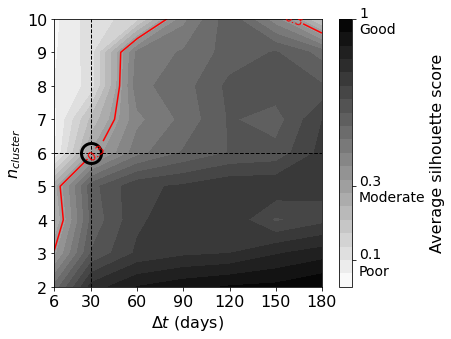

In [21]:
fig = plt.figure(figsize=(6.5,5))
n_cluster = 6
lag = 5
out = plt.contourf(lags[:], n_clusters, silhouette_avg_matrix[:,:].T, 20, cmap='binary', vmin=0, vmax=0.8, clim=(0,1))
CS = plt.contour(lags[:], n_clusters, silhouette_avg_matrix[:,:].T, levels=[0.3], colors='r', vmin=0.8, vmax=1, clim=(0,1))
xlim = plt.xlim()
ylim = plt.ylim()
plt.vlines(lag, ylim[0], ylim[1], color='k', linestyle='--', lw=1)
plt.hlines(n_cluster, xlim[0], xlim[1], color='k', linestyle='--', lw=1)
plt.plot(lag, n_cluster, 'wo', ms=20, markeredgecolor='k', markeredgewidth=3, markerfacecolor="None")
plt.clabel(CS, inline=True, fontsize=12)
tmp = plt.yticks(n_clusters)
ax = plt.gca()
ax.set_xticklabels(["{:d}".format(x*6) for x in lags])
ax.set_ylabel("$n_{cluster}$")
ax.set_xlabel("$\Delta t$ (days)")
tmp = plt.xticks(lags)
cb = plt.colorbar(out, format="%.2f")
cb.set_label("Average silhouette score")
cb.set_ticks([0.08, 0.3, 0.8])
cb.set_ticklabels(["0.1\nPoor", "0.3\nModerate", "1\nGood"])
cb.ax.tick_params(labelsize=14)
plt.tight_layout()
fig.savefig("./figures/figure_s3.png", dpi=200)

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

5
For n_cluster = 2 The average silhouette_score is : 0.6557285038068239
5
For n_cluster = 4 The average silhouette_score is : 0.48984740263541504
5
For n_cluster = 6 The average silhouette_score is : 0.2817837159903978
5
For n_cluster = 8 The average silhouette_score is : 0.09335629978677501


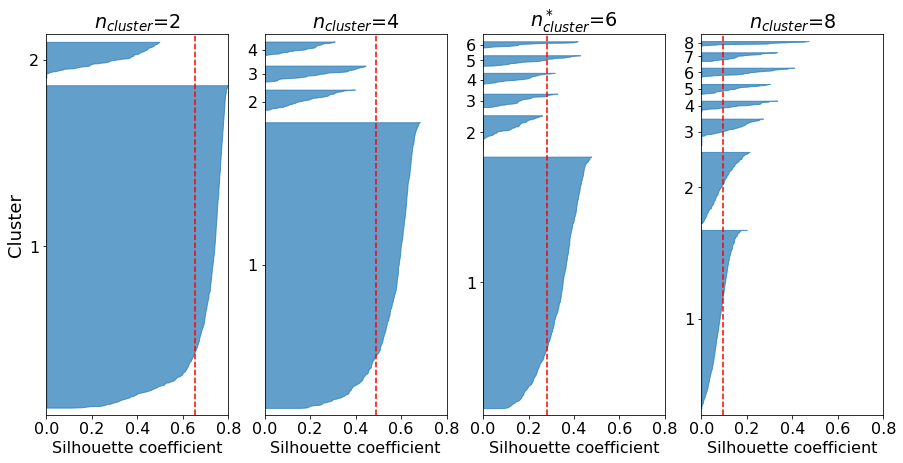

In [23]:
fig, axs = plt.subplots(1,4, figsize=(15, 7))
n_clusters = [2, 4, 6, 8]
for kk in range(4):
    ax = axs[kk]
    yticks = []
    lag = 5
    print (lag)
    nskip = 50
    n_cluster = n_clusters[kk]
    
    insar_data_vec_0_diff = np.diff(insar_data_vec_0[::lag,:], axis=0)
    Data = insar_data_vec_0_diff.T[::nskip, :]
    buffer = Data.shape[0] / 50
    y_lower = buffer

    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Data)
    cat = kmeans.predict(Data)

    ax.set_xlim([0, 0.8])
    ax.set_ylim([0, len(Data) + (n_cluster + 1) * buffer])

    n_per_cat = []
    for ii in range(kmeans.n_clusters):
        n_per_cat.append((cat == ii).sum())
    ind_sort = np.argsort(n_per_cat)[::-1]

    cat_reord = cat.copy()
    for ii, ind in enumerate(ind_sort):
        cat_reord[cat==ind] = ii


    silhouette_avg = silhouette_score(Data, cat_reord)
    print(
        "For n_cluster =",
        n_cluster,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(Data, cat_reord)

    for i in range(n_cluster):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cat_reord == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = 'C0'
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        yticks.append(y_lower + 0.5 * size_cluster_i)
        # Compute the new y_lower for next plot
        y_lower = y_upper + buffer  # 10 for the 0 samples

    # ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("Silhouette coefficient")
    if kk == 0:
        ax.set_ylabel("Cluster", fontsize=18)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.arange(n_cluster)+1)  # Clear the yaxis labels / ticks
    if kk == 2:
        ax.set_title("$n_{cluster}^*$"+"={:d}".format(n_cluster))
    else:
        ax.set_title("$n_{cluster}$"+"={:d}".format(n_cluster))
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
fig.savefig("./figures/figure_s4.png", dpi=200)

1
For n_cluster = 6 The average silhouette_score is : 0.033468136244371983
5
For n_cluster = 6 The average silhouette_score is : 0.2817837159903978
10
For n_cluster = 6 The average silhouette_score is : 0.42459422312779316
15
For n_cluster = 6 The average silhouette_score is : 0.48428428126706025


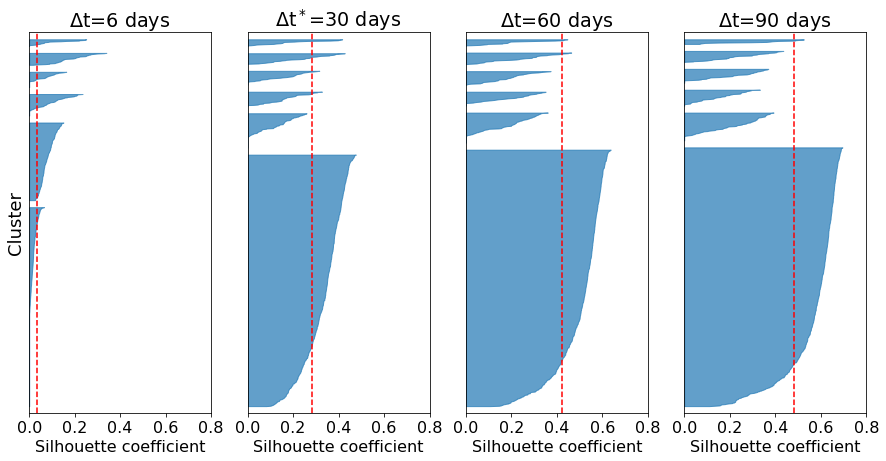

In [24]:
fig, axs = plt.subplots(1,4, figsize=(15, 7))
lags = [1, 5, 10, 15]
for kk in range(4):
    ax = axs[kk]
    yticks = []   
    lag = lags[kk]
    print (lag)
    nskip = 50
    n_cluster = 6
    
    insar_data_vec_0_diff = np.diff(insar_data_vec_0[::lag,:], axis=0)
    Data = insar_data_vec_0_diff.T[::nskip, :]
    buffer = Data.shape[0] / 50
    y_lower = buffer

    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Data)
    cat = kmeans.predict(Data)

    ax.set_xlim([0, 0.8])
    ax.set_ylim([0, len(Data) + (n_cluster + 1) * buffer])

    n_per_cat = []
    for ii in range(kmeans.n_clusters):
        n_per_cat.append((cat == ii).sum())
    ind_sort = np.argsort(n_per_cat)[::-1]

    cat_reord = cat.copy()
    for ii, ind in enumerate(ind_sort):
        cat_reord[cat==ind] = ii


    silhouette_avg = silhouette_score(Data, cat_reord)
    print(
        "For n_cluster =",
        n_cluster,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(Data, cat_reord)

    for i in range(n_cluster):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cat_reord == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = 'C0'
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        yticks.append(y_lower + 0.5 * size_cluster_i)
        # Compute the new y_lower for next plot
        y_lower = y_upper + buffer  # 10 for the 0 samples

    # ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("Silhouette coefficient")
    if kk == 0:
        ax.set_ylabel("Cluster", fontsize=18)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    if kk==1:
        ax.set_title("$\Delta$t$^*$"+"={:d} days".format(lag*6))
    else:
        ax.set_title("$\Delta$t"+"={:d} days".format(lag*6))
fig.savefig("./figures/figure_s5.png", dpi=200)

## Conduct a K-means clustering with $n_{cluster}^{*}$ and $\Delta t^{*}$

In [25]:
lag = 5
n_cluster = 6

insar_data_vec_0_diff = np.diff(insar_data_vec_0[::lag,:], axis=0)
Data = insar_data_vec_0_diff.T[:, :]
buffer = Data.shape[0] / 50

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Data)
cat = kmeans.predict(Data)

# Sort indicies by the number of samples in a cluster
n_per_cat = []
for ii in range(kmeans.n_clusters):
    n_per_cat.append((cat == ii).sum())
ind_sort = np.argsort(n_per_cat)[::-1]

cat_reord = cat.copy()
for ii, ind in enumerate(ind_sort):
    cat_reord[cat==ind] = ii

# Resort indices for the paper
cat_reord_final = cat_reord.copy()
for ii, ind in enumerate([0, 1, 3, 4, 2, 5]):
    cat_reord_final[cat_reord==ind] = ii    
    
cat_matrix = np.zeros(ny*nx, dtype=float) * np.nan
cat_matrix[inds_active] = cat_reord_final
cat_matrix = cat_matrix.reshape(ny, nx)

In [26]:
import matplotlib.colors as colors
# label_colors = ['tab:blue', 'mediumaquamarine', 'tab:green', 'peru', 'tab:red', 'purple']
label_colors =  ['tab:blue', 'mediumaquamarine', 'peru', 'tab:red', 'tab:green', 'purple']
colorscmap = colors.ListedColormap(label_colors)
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = colors.BoundaryNorm(boundaries, colorscmap.N, clip=True)
lithology_lables = ["1", "2", "3", "4", "5", "6"]

In [27]:
x_node = np.r_[ds.lon.values-0.005, ds.lon.values[-1]+0.005]
y_node = np.r_[ds.lat.values-0.005, ds.lat.values[-1]+0.005]

In [28]:
perc_cluster = (np.array(n_per_cat)[ind_sort] / np.array(n_per_cat).sum()) * 100

In [29]:
x = ds.lon
y = ds.lat
X, Y = np.meshgrid(x, y)
x_vec = X.flatten()[inds_active]
y_vec = Y.flatten()[inds_active]

In [30]:
import geopandas
import rasterio

In [31]:
xc1, yc1 = -120.5831753167395, 36.80342202982594
xc2, yc2 = -121.74604660386822, 38.496350972633564

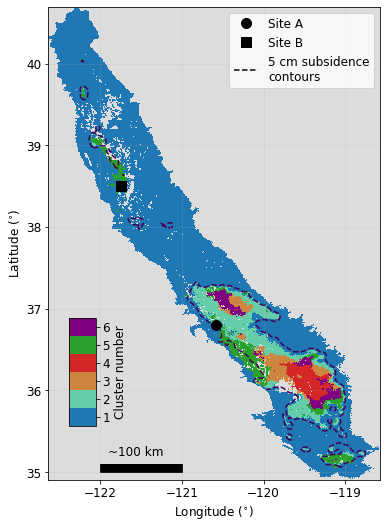

In [32]:
matplotlib.rcParams['font.size'] = 12
xlim = (-122.63322482168999, -118.57322482169) 
ylim = (34.9051464665677, 40.69514646656771)
ii = -1
labels = [label+" ({:.0f}%)".format(perc_cluster[ii]) for ii, label in enumerate(lithology_lables)]
fig, ax = plt.subplots(1,1, figsize=(5*1.5, 5*1.5))
out = ax.pcolormesh(x_node, y_node, cat_matrix, cmap=colorscmap, vmin=-0.5, vmax=n_cluster-0.5)
ax.plot(xc1, yc1, marker='o',color='k', label="Site A", ms=10, linestyle='None')
ax.plot(xc2, yc2, marker='s',color='k', label="Site B", ms=10, linestyle='None')
left, bottom, width, height = [0.23, 0.2, 0.05, 0.2]
cax = fig.add_axes([left, bottom, width, height])

cb = plt.colorbar(out, cax=cax)

cb.set_label("Cluster number")
cb.set_ticks(np.arange(6))
cb.set_ticklabels(lithology_lables)
ax.fill([-122, -121, -121, -122, -122], [35, 35, 35.1, 35.1, 35], color='k')
ax.text(-121.9, 35.2, "~100 km")
ax.set_xticks(np.arange(4)-122)
ax.set_aspect(1)
ax.grid(True, alpha=0.2)
ax.set_ylabel("Latitude ($^{\circ}$)")
ax.set_xlabel("Longitude ($^{\circ}$)")
cs = ax.contour(ds.lon.values, ds.lat.values, DATA_IDW, levels=[-50], linestyles=['--'])
ax.plot(0, 0, 'k--', label='5 cm subsidence\ncontours')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_facecolor('gainsboro')
l = ax.legend()
for text in l.get_texts():
    text.set_color("k")
plt.tight_layout()
fig.savefig(work_dir+'figure_1.png', dpi=200)

In [50]:
from shapely.geometry import Point, LineString, shape
import geopandas as gpd
paths = cs.collections[0].get_paths()
geometry = [LineString(p.vertices.astype(float)) for p in paths]
df_tmp = pd.DataFrame(data=np.arange(16), columns=['name'])
geo_df = gpd.GeoDataFrame(df_tmp, geometry=geometry)
geo_df = geo_df.set_crs(epsg=4326)
geo_df.to_file("../data/output_data/subsidence_5cm")

In [49]:
ds_cluster = xr.Dataset(
    {"insar_cluster": (("lat", "lon"), cat_matrix)},
    coords={
        "lon": ds.lon.values,
        "lat": ds.lat.values
    },
)
ds_cluster.to_netcdf("../data/output_data/insar_cluster.nc")

In [36]:
insar_data_vec = ds.insar_median.values.reshape((ds.time.size, ds.lat.size*ds.lon.size))[:,inds_active]
insar_data_vec_0 = insar_data_vec.copy()
insar_data_vec_0[np.isnan(insar_data_vec)] = 0.

In [37]:
import datetime
import datetime
import matplotlib.dates as mdates

In [38]:
scores = silhouette_samples(insar_data_vec_0[30:,:].T, cat_reord_final)
perc_cluster_final = perc_cluster[[0, 1, 3, 4, 2, 5]]

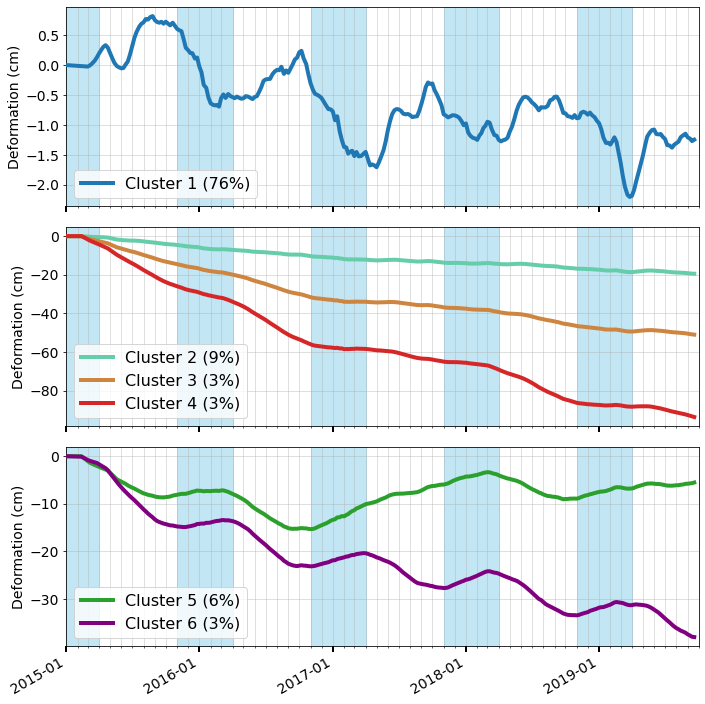

In [39]:
matplotlib.rcParams['font.size'] = 14
means = []
fig, axs = plt.subplots(3,1, figsize=(10, 10))
ax1, ax2, ax3 = axs
ii = 0
tmp = insar_data_vec[:,cat_reord_final==ii][:,:]
tmp[np.isnan(tmp)] = 0.
inds_tmp = scores[cat_reord_final==ii][:] > 0.
mean_tmp = tmp[:,inds_tmp].mean(axis=1)
out = ax1.plot(ds.time, 0.1*mean_tmp, alpha=1, color=label_colors[ii], lw=4, zorder=1000, label="Cluster {:d} ({:.0f}%)".format(ii+1, perc_cluster_final[ii]))
means.append(mean_tmp)
for ii in [1, 2, 3]:
    tmp = insar_data_vec[:,cat_reord_final==ii][:,:]
    tmp[np.isnan(tmp)] = 0.
    inds_tmp = scores[cat_reord_final==ii][:] > 0.
    mean_tmp = tmp[:,inds_tmp].mean(axis=1)
    out = ax2.plot(ds.time, 0.1*mean_tmp, alpha=1, color=label_colors[ii], lw=4, zorder=1000, label="Cluster {:d} ({:.0f}%)".format(ii+1, perc_cluster_final[ii]))
    means.append(mean_tmp)
for ii in [4, 5]:
    tmp = insar_data_vec[:,cat_reord_final==ii][:,:]
    tmp[np.isnan(tmp)] = 0.
    inds_tmp = scores[cat_reord_final==ii][:] > 0.
    mean_tmp = tmp[:,inds_tmp].mean(axis=1)
    out = ax3.plot(ds.time, 0.1*mean_tmp, alpha=1, color=label_colors[ii], lw=4, zorder=1000, label="Cluster {:d} ({:.0f}%)".format(ii+1, perc_cluster_final[ii]))  
    means.append(mean_tmp)
for ax in axs:
    ax.set_ylabel("Deformation (cm)")
    ylim = ax.get_ylim()
    for year in [2015, 2016, 2017, 2018, 2019, 2020]:
        ax.fill_betweenx(ylim, datetime.date(year-1, 11, 1), datetime.date(year, 4, 1), color='skyblue', alpha=0.5)
    ax.set_ylim(ylim)
    fmt_half_year = mdates.MonthLocator([1])
    ax.xaxis.set_major_locator(fmt_half_year)
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)
    ax.set_xlim(ds.time.min(), datetime.date(2019, 10, 1))
    ax.grid(True, which='both', alpha=0.5)    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', length=6, width=2)
    ax.legend(loc=3, fontsize=16)
fig.autofmt_xdate()  
plt.tight_layout()
fig.savefig(work_dir+'figure_3', dpi=200)

In [40]:
for ii in range(6):
    print ((means[ii][-1]/5*0.1))

-0.2493844619422555
-3.8950526315789475
-10.207204068658605
-18.744196769456686
-1.1056421052631582
-7.601030303030304


In [41]:
insar_data_vec = ds.insar_median.values.reshape((ds.time.size, ds.lat.size*ds.lon.size))[:,inds_active]

In [42]:
xy_vec = np.c_[X.flatten()[inds_active], Y.flatten()[inds_active]]

In [43]:
for ii in range(6):
    ind = cat_reord_final==ii
    values = insar_data_vec[-1,:][ind]
    values_act = values[~np.isnan(values)]
    print (ii+1, np.round(np.mean(values_act) * 0.1 / 5))

1 -0.0
2 -4.0
3 -10.0
4 -19.0
5 -2.0
6 -11.0
